In [1]:
import mitsuba as mi
import drjit as dr
import numpy as np
from sionna.rt import load_scene, Transmitter, Receiver, Camera, RadioMapSolver, PathSolver
import matplotlib.pyplot as plt

In [2]:
mi.set_variant("llvm_ad_mono_polarized")

In [3]:
import sionna.rt as rt

In [4]:
scene_path = r"C:\Users\sawyer\Documents\sionna_rt_jamming\data\downtown_chicago\DowntownChicago1KM.xml"
# concrete for floor/walls, metal for roofs
scene = load_scene(scene_path)

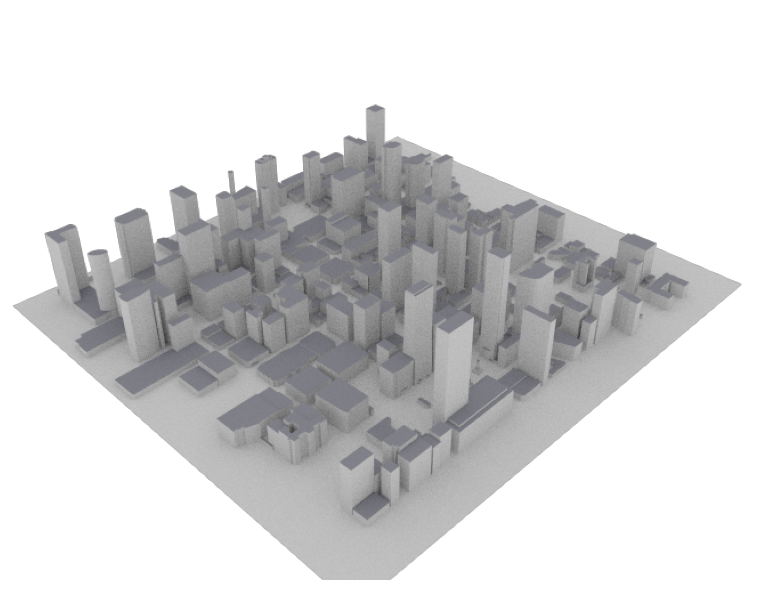

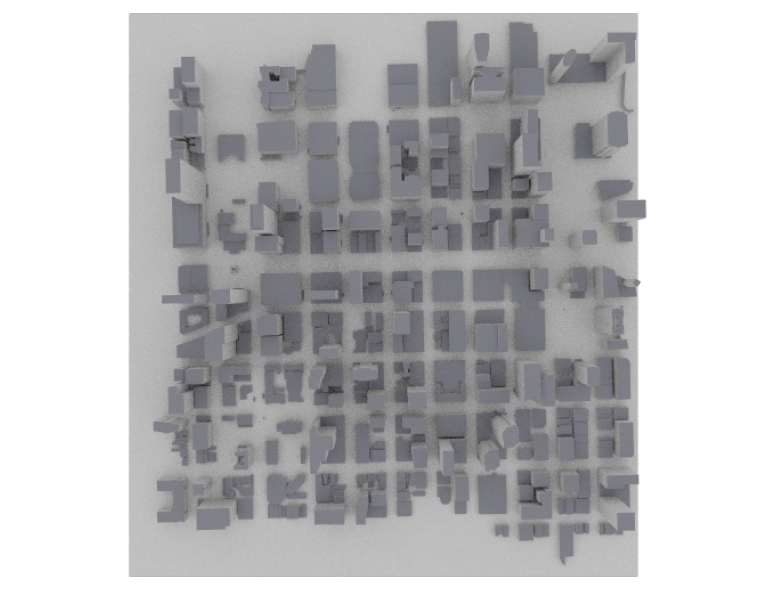

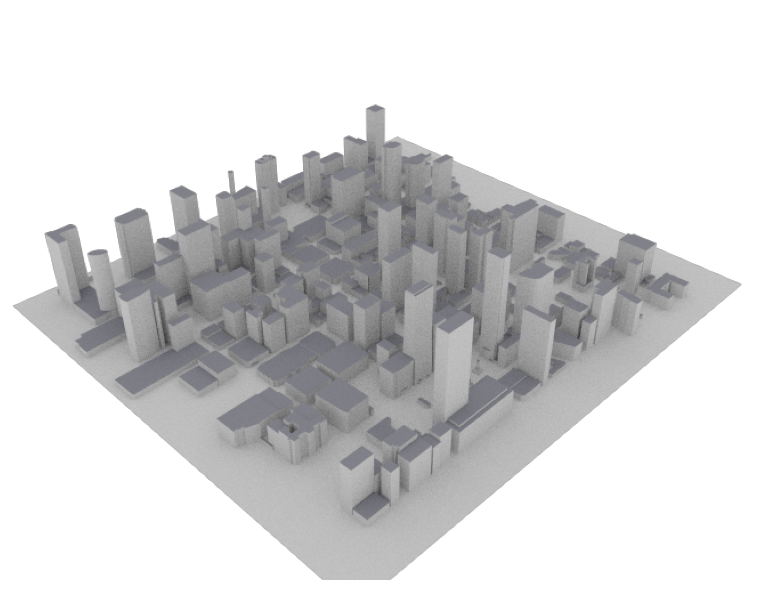

In [5]:
overhead = Camera(position=(0.0, 0.0, 2000.0))
overhead.look_at((0.0,0.0,0.0))
scene.render(camera=overhead)

isometric = Camera(position=(1200.0, 1200.0, 1200.0))
isometric.look_at((0.0,0.0,0.0))
scene.render(camera=isometric)

# Camera on render should be Z up, Y forwards!

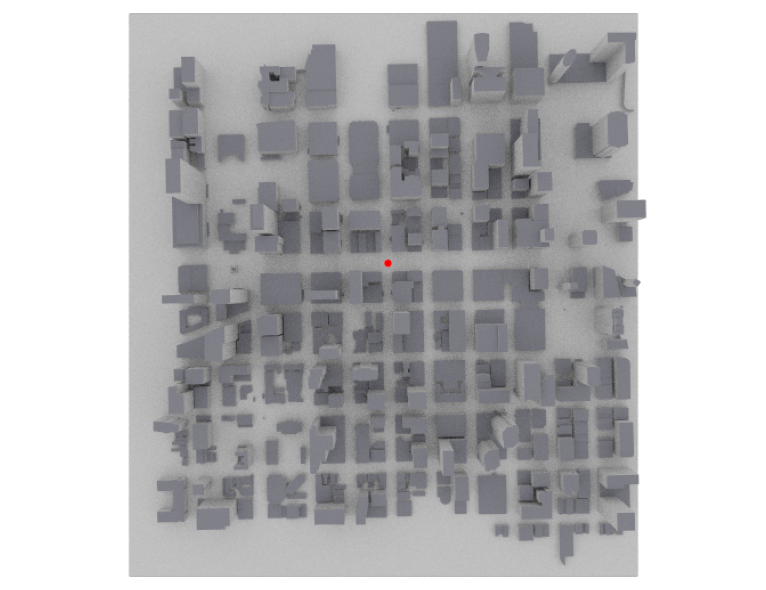

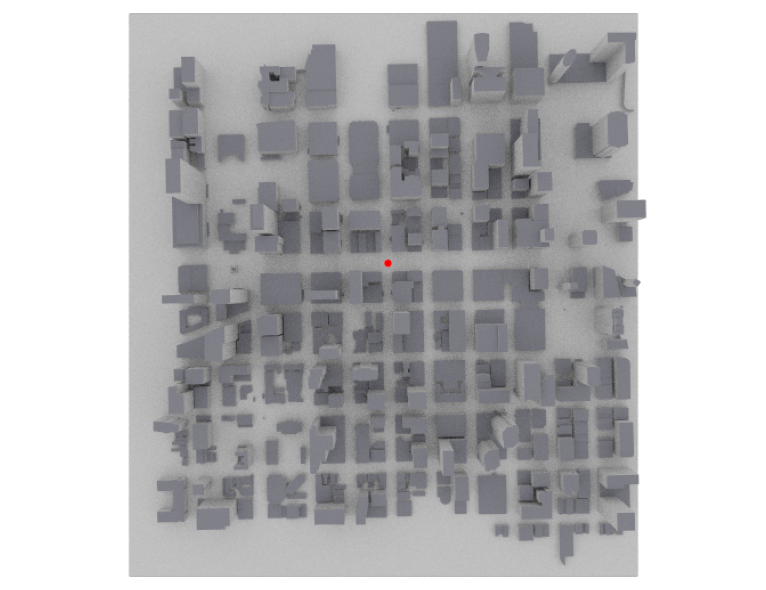

In [6]:
# Set up antenna arrays
scene.tx_array = rt.PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")
scene.rx_array = rt.PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")

# Add Transmitter
tx = Transmitter(name="Tx1", position=[70,-10,10], color=[1.0, 0.0, 0.0])
scene.add(tx)
# Visualize scene with transmitter and receivers in place
cam = Camera(position=(0.0, 0.0, 2000.0))
cam.look_at((0.0, 0.0, 0.0)) 
scene.render(camera=cam)

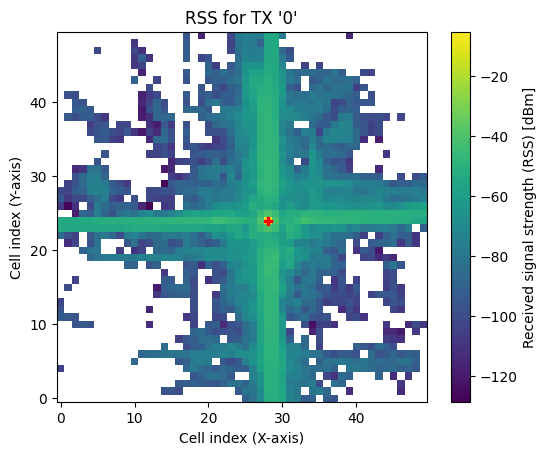

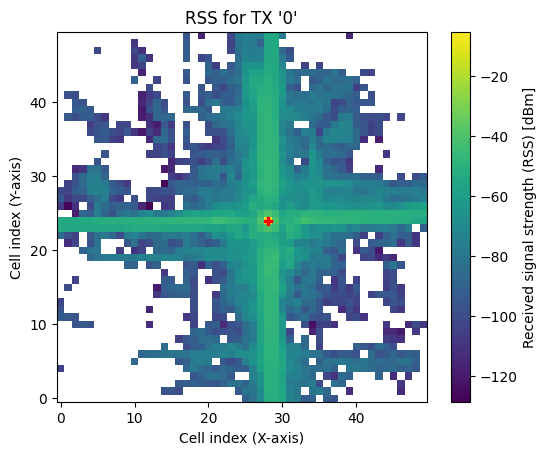

In [ ]:

x_min, x_max = -500, 500
y_min, y_max = -500, 500
z_height = 10
cell_size = (20, 20)

map_width = x_max - x_min
map_height = y_max - y_min
map_center = [(x_min + x_max) / 2, (y_min + y_max) / 2, z_height]

rm_solver = RadioMapSolver()

rm = rm_solver(
    scene,
    max_depth=5,                    # Maximum number of ray-scene interactions
    samples_per_tx=10**8,           # More samples = less noise but more memory
    cell_size=cell_size,            # Resolution of the radio map
    center=map_center,              # Center of the coverage area
    size=[map_width, map_height],   # Total size of the radio map
    orientation=[0, 0, 0]           # Horizontal orientation (Z-up)
)


rm.show(metric="rss", tx=0)


CIR shape: (2, 20, 1, 1, 1, 39, 1)
Number of receivers: 20
Rx_0 at position [ 200.37306 -468.29617   10.     ]: 0 paths, total power: -inf dB
Rx_1 at position [139.16724 375.80374  10.     ]: 4 paths, total power: -116.67 dB
Rx_2 at position [ 75.63388 153.4164   10.     ]: 23 paths, total power: -85.12 dB
Rx_3 at position [277.08917 236.78642  10.     ]: 7 paths, total power: -118.09 dB
Rx_4 at position [-48.577866  27.146446  10.      ]: 6 paths, total power: -124.44 dB
Rx_5 at position [ 94.93155 110.66918  10.     ]: 12 paths, total power: -100.97 dB
Rx_6 at position [368.62103  -25.261635  10.      ]: 6 paths, total power: -112.29 dB
Rx_7 at position [293.69086   71.942955  10.      ]: 10 paths, total power: -124.09 dB
Rx_8 at position [-65.237976 104.74343   10.      ]: 2 paths, total power: -120.84 dB
Rx_9 at position [ 140.8145  -421.03592   10.     ]: 6 paths, total power: -110.72 dB
Rx_10 at position [167.35594  -46.647556  10.      ]: 39 paths, total power: -107.41 dB
Rx_11 

C:\Users\sawyer\AppData\Local\Temp\ipykernel_33076\2095258179.py:41: RuntimeWarning: divide by zero encountered in log10
  print(f"Rx_{i} at position {positions[i]}: {num_paths} paths, total power: {10*np.log10(total_power):.2f} dB")


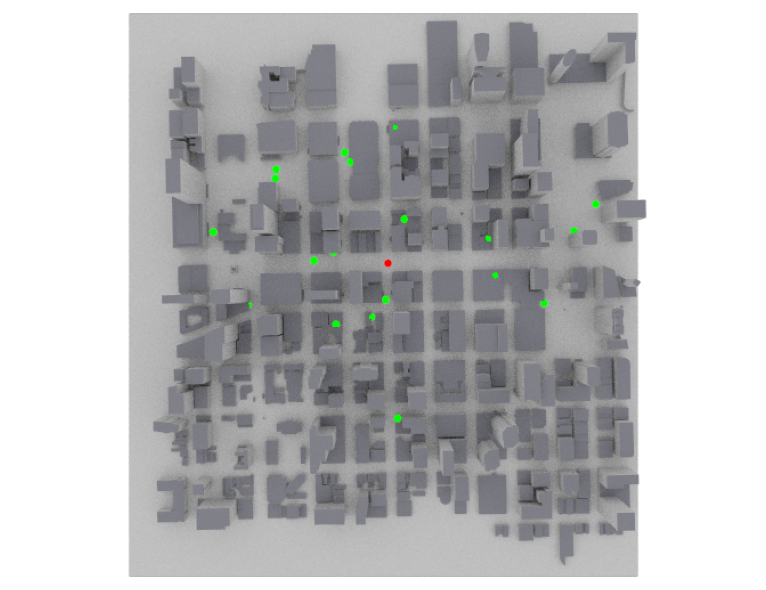

In [8]:
# Sample specific positions from the RadioMap for PathSolver analysis
positions, cell_indices = rm.sample_positions(
    num_pos=20,
    metric='rss',
    min_val_db=-80,
    max_dist=500
)

# Convert to numpy and add receivers at those positions
positions = positions.numpy()
positions = np.squeeze(positions, axis=0)  # Shape: [10, 3]

for i, pos in enumerate(positions):
    rx = Receiver(name=f"Rx_{i}", position=pos, color=[0.0, 1.0, 0.0])
    scene.add(rx)

cam = Camera(position=(0.0, 0.0, 2000.0))
cam.look_at((0.0, 0.0, 0.0)) 
scene.render(camera=cam)

# Now use PathSolver to get detailed path information for these receivers
path_solver = PathSolver()
paths = path_solver(scene, max_depth=5)

# Get channel impulse response
a, tau = paths.cir()

# Convert to numpy array
a = np.array(a)
tau = np.array(tau)

print(f"CIR shape: {a.shape}")
print(f"Number of receivers: {len(positions)}")

# Analyze paths for each receiver
for i in range(len(positions)):
    a_rx = a[0, i, 0, 0, 0, :, 0]  # Get path coefficients for receiver i
    num_paths = np.sum(np.abs(a_rx) > 1e-10)  # Count significant paths
    total_power = np.sum(np.abs(a_rx)**2)
    
    print(f"Rx_{i} at position {positions[i]}: {num_paths} paths, total power: {10*np.log10(total_power):.2f} dB")

# You can also visualize specific paths
scene.preview(paths=paths, clip_at=20)

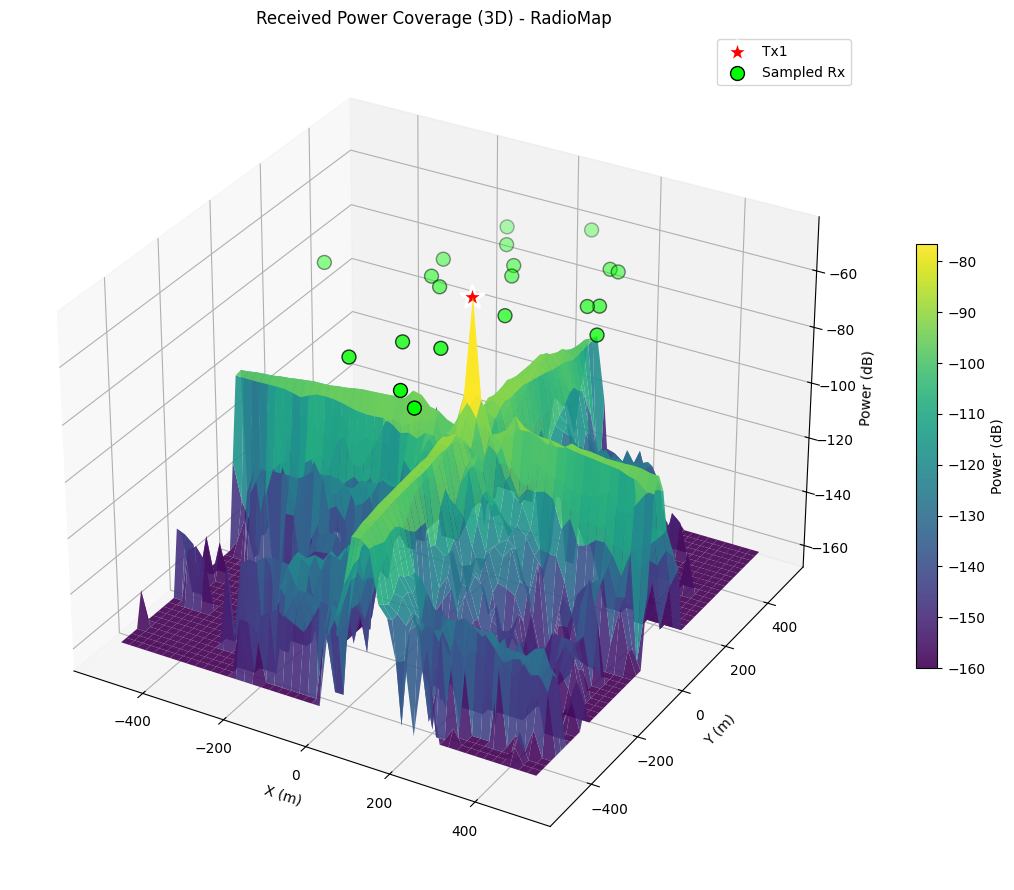


Power range: -160.00 to -49.18 dB
Grid shape: (50, 50)


In [ ]:
#--------------------------Visualize RadioMap Data in 3D----------------------------#


# Extract RadioMap data
path_gain = np.array(rm.path_gain)  # Shape: [num_tx, cells_y, cells_x]
rss_data = path_gain[0, :, :]  # Get first transmitter

# Convert to dB
power_grid_db = 10 * np.log10(rss_data + 1e-16)

# Create coordinate grids
num_cells_y, num_cells_x = power_grid_db.shape
x_coords = np.linspace(x_min, x_max, num_cells_x)
y_coords = np.linspace(y_min, y_max, num_cells_y)
X, Y = np.meshgrid(x_coords, y_coords)

# Create 3D surface plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, power_grid_db, cmap='viridis', 
                       edgecolor='none', alpha=0.9)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Power (dB)')
ax.set_title('Received Power Coverage (3D) - RadioMap')

# Add transmitter location (at position [70, -10, 10])
tx_pos = [70, -10]
ax.scatter([tx_pos[0]], [tx_pos[1]], [power_grid_db.max()], 
           color='red', s=300, marker='*', label='Tx1', 
           edgecolors='white', linewidths=2)

# Add sampled receiver positions
if len(positions) > 0:
    ax.scatter(positions[:, 0], positions[:, 1], 
               [power_grid_db.max()] * len(positions),
               color='lime', s=100, marker='o', label='Sampled Rx',
               edgecolors='black', linewidths=1)

fig.colorbar(surf, ax=ax, shrink=0.5, label='Power (dB)')
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nPower range: {power_grid_db.min():.2f} to {power_grid_db.max():.2f} dB")

